# 1. Movies Dataset

In this notebook, we'll explore the [MovieLens dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=tag.csv), which contains information about movies and their respective ratings, from 1995 to 2015.

Let's initialize some variables and import some necessary packages for our exercise.

### 1.1 Import packages

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, explode, split, year
import seaborn as sns
import matplotlib.pyplot as plt

### 1.2 Create Spark session

New spark session will be created, with the necessary Delta libraries.

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Movies") \
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

### 1.3 Notebook variables

Variables pointing to the raw CSV dataset used in this notebook - make sure to adjust them if the paths below are wrong.

In [36]:
RATINGS_DATASET_PATH = "./rating.csv"
MOVIE_DATASET_PATH = "./movie.csv"

# 2. Working with the dataset

We'll create the DataFrames to manipulate the necessary information contained in the raw dataset. They consist of:

- **Movies Dataset**: contains movie information, with columns `movieId`, `title` and `genres`.
- **Ratings Dataset**: contains ratings of movies by users, with columns `userId`, `movieId`, `rating`, `timestamp`. 

### 2.1 Creating the DataFrames

In [34]:
# Load ratings dataset
ratings_df = spark.read.csv(RATINGS_DATASET_PATH, header=True, inferSchema=True)
# Load movies dataset
movies_df = spark.read.csv(MOVIE_DATASET_PATH, header=True, inferSchema=True)

In [37]:
# Check the first 10 rows in each DataFrame
ratings_df.show(10)
movies_df.show(10)

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
|     1|    112|   3.5|2004-09-10 03:09:00|
|     1|    151|   4.0|2004-09-10 03:08:54|
|     1|    223|   4.0|2005-04-02 23:46:13|
|     1|    253|   4.0|2005-04-02 23:35:40|
|     1|    260|   4.0|2005-04-02 23:33:46|
+------+-------+------+-------------------+
only showing top 10 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Rom

## 2.1 Most popular movies

Calculate the movies with the highest average rating. We discard movies with less than 100 ratings to avoid considerance movies with less significance in terms of reviews.

In [38]:
# Compute average rating and number of ratings for each movie
popular_movies_df = ratings_df.groupBy("movieId") \
    .agg(avg("rating").alias("avg_rating"), count("rating").alias("num_ratings")) \
    .filter(col("num_ratings") > 100) \
    .join(movies_df, on="movieId") \
    .orderBy(col("avg_rating").desc())

# Show the top 10 best rated movies
popular_movies_df.show(10)

+-------+-----------------+-----------+--------------------+--------------------+
|movieId|       avg_rating|num_ratings|               title|              genres|
+-------+-----------------+-----------+--------------------+--------------------+
|    318|4.446990499637029|      63366|Shawshank Redempt...|         Crime|Drama|
|    858|4.364732196832306|      41355|Godfather, The (1...|         Crime|Drama|
|     50|4.334372207803259|      47006|Usual Suspects, T...|Crime|Mystery|Thr...|
|    527|4.310175010988133|      50054|Schindler's List ...|           Drama|War|
|   1221|4.275640557704942|      27398|Godfather: Part I...|         Crime|Drama|
|   2019|  4.2741796572216|      11611|Seven Samurai (Sh...|Action|Adventure|...|
|    904|4.271333600779414|      17449|  Rear Window (1954)|    Mystery|Thriller|
|   7502|4.263182346109176|       4305|Band of Brothers ...|    Action|Drama|War|
|    912|4.258326830670664|      24349|   Casablanca (1942)|       Drama|Romance|
|    922|4.25693

## 2.2 Rating by genre

We'll conduct an analysis of movies by genre, and (graphically) answer questions like:

- What are the best rated genres?
- What's the distribution of ratings amongst the best movie categories?
- How have the movie genres evolved in the eye of the public through the years?

The first manipulation we'll do is extract the individual genres of each movie. As you may have noticed, each movie can have more than one genre - they're separated by the "|" character in the `genre` column.

In [39]:
# Split genres into multiple rows
genre_df = movies_df.withColumn("genre", explode(split(col("genres"), "\\|")))  # Split genres by "|"

# Join with ratings dataset, so we have the user rating info.
genre_ratings_df = ratings_df.join(genre_df, on="movieId")

# Compute average rating per genre
avg_genre_ratings_df = genre_ratings_df.groupBy("genre").agg(avg("rating").alias("avg_rating"))

# Show the top three best rated genres
avg_genre_ratings_df.orderBy(col("avg_rating").desc()).show(3)

+-----------+------------------+
|      genre|        avg_rating|
+-----------+------------------+
|  Film-Noir|  3.96538126070082|
|        War|3.8095307347384844|
|Documentary|3.7397176834178865|
+-----------+------------------+
only showing top 3 rows



We'll store the top 3 genres in the Python list `top_3_genres`.

In [40]:
# Store the top 5 most well rated movies
top_3_genres = [row["genre"] for row in avg_genre_ratings_df.orderBy(col("avg_rating").desc()).select("genre").limit(3).collect()]

print(f"The top-3 best rated genres are: {top_3_genres}")

The top-3 best rated genres are: ['Film-Noir', 'War', 'Documentary']


Next, we'll create a new DataFrame containing the ratings of the top 3 best rated genres only.

In [42]:
top_3_genres_movie_ratings_df = genre_ratings_df.filter(genre_ratings_df["genre"].isin(top_3_genres))

print(f"There are {top_3_genres_movie_ratings_df.count()} ratings for the top 3 best genres.")

# Show first 10 user ratings.
top_3_genres_movie_ratings_df.show(10)

There are 1509926 ratings for the top 3 best genres.
+-------+------+------+-------------------+--------------------+--------------------+-----+
|movieId|userId|rating|          timestamp|               title|              genres|genre|
+-------+------+------+-------------------+--------------------+--------------------+-----+
|    151|     1|   4.0|2004-09-10 03:08:54|      Rob Roy (1995)|Action|Drama|Roma...|  War|
|   1090|     1|   4.0|2005-04-02 23:44:13|      Platoon (1986)|           Drama|War|  War|
|   1208|     1|   3.5|2005-04-02 23:33:35|Apocalypse Now (1...|    Action|Drama|War|  War|
|   1217|     1|   3.5|2005-04-02 23:33:30|          Ran (1985)|           Drama|War|  War|
|   1222|     1|   3.5|2005-04-02 23:30:37|Full Metal Jacket...|           Drama|War|  War|
|   1262|     1|   3.5|2005-04-02 23:32:15|Great Escape, The...|Action|Adventure|...|  War|
|   1920|     1|   3.5|2005-04-02 23:54:58|Small Soldiers (1...|Animation|Childre...|  War|
|   2944|     1|   4.0|2005

### Plotting reviews and distributions of the top 3 genres by year

We'll now make use of the plotting libraries `matplotlib`, `seaborn` and the data analysis library `pandas` to visually verify the evolution of ratings amongst the top three best movie categories.

First, we convert the Spark DataFrame `top_3_genres_movie_ratings_df` to a pandas DataFrame - although the name is identical, they're different classes. It so happens that the pandas DataFrame fits better with the plotting functions of `seaborn` and `matplotlib` that we'll use. In fact, this operation is so often executed that PySpark offers a native function [toPandas()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html) to convert a PySpark DataFrame to a pandas one.

In [43]:
top_3_genres_movie_ratings_pd = top_3_genres_movie_ratings_df.toPandas()

With the pandas DataFrame at hand, we'll give a shot at checking the statistical distribution of the top-tier categories movie ratings.

We'll use the seaborn boxplot function to obtain a visual representation of means, percentiles and outliers.

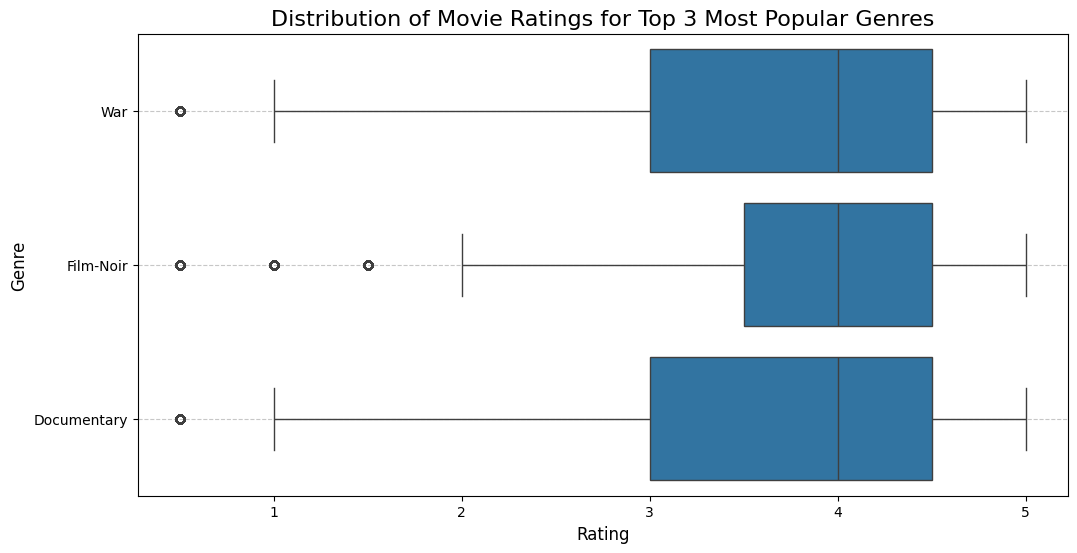

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_3_genres_movie_ratings_pd, x="rating", y="genre")
plt.title("Distribution of Movie Ratings for Top 3 Most Popular Genres", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

That wasn't so visually appealing, right? We clearly see that all of the top 3 genres have a mean rating of 4, and slightly similar upper quartiles (75th percentiles).

Let's try to plot more insightful observations - such as how the ratings evolved by year for the top 3 genres.

We'll start by deriving the year from the timestamp of the rating - PySpark function `year` helps us with that. Then, we'll group the resulting PySpark DataFrame by year and genre, so that we can compute the yearly information - number of ratings and average rating - by group.

In [52]:
# Create a new column "year" from the existing "timestamp" column.
movie_reviews_top_3_df = top_3_genres_movie_ratings_df.withColumn("year", year("timestamp"))

# Compute average rating and total ratings per genre and year
top_3_genres_movie_reviews_by_genre_and_year = movie_reviews_top_3_df.groupBy("year", "genre") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("num_ratings")
    ) \
    .orderBy("year", "genre")

We're now ready to plot the information. We'll use seaborn's [scatterplot function](https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn-scatterplot) to construct a scatter plot of movie ratings per year.

Again, we'll convert our PySpark DataFrame `movie_reviews_by_genre_and_year` to a pandas DataFrame. Then, we'll use the function `show_scatterplot` that takes in a pandas DataFrame with the necessary columns and creates a scatter plot for the information

In [50]:
def show_scatterplot(data, plot_title=""):
    # Normalize the bubble size for better visualization
    max_size = 700  # Maximum size for bubbles
    min_size = 200  # Minimum size for bubbles

    # Add a "size" dimension to the pandas DataFrame, for aiding the scatterplot function.
    data["size"] = ((data["num_ratings"] / data["num_ratings"].max()) * (max_size - min_size) + min_size)
    
    # Plot the scatterplot
    plt.figure(figsize=(16, 8))
    sns.scatterplot(
        data=data,
        x="year",
        y="avg_rating",
        hue="genre",
        size="size",
        sizes=(min_size, max_size),  # Minimum and maximum bubble size
        palette="tab10",
        alpha=0.7
    )
    
    # Set x-axis ticks to be every unique year
    unique_years = sorted(aggregated_pd["year"].unique())
    plt.xticks(unique_years, rotation=45)  # Rotate labels if needed for better readability
    
    # Add labels and title
    plt.title(plot_title, fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Rating", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Genre")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

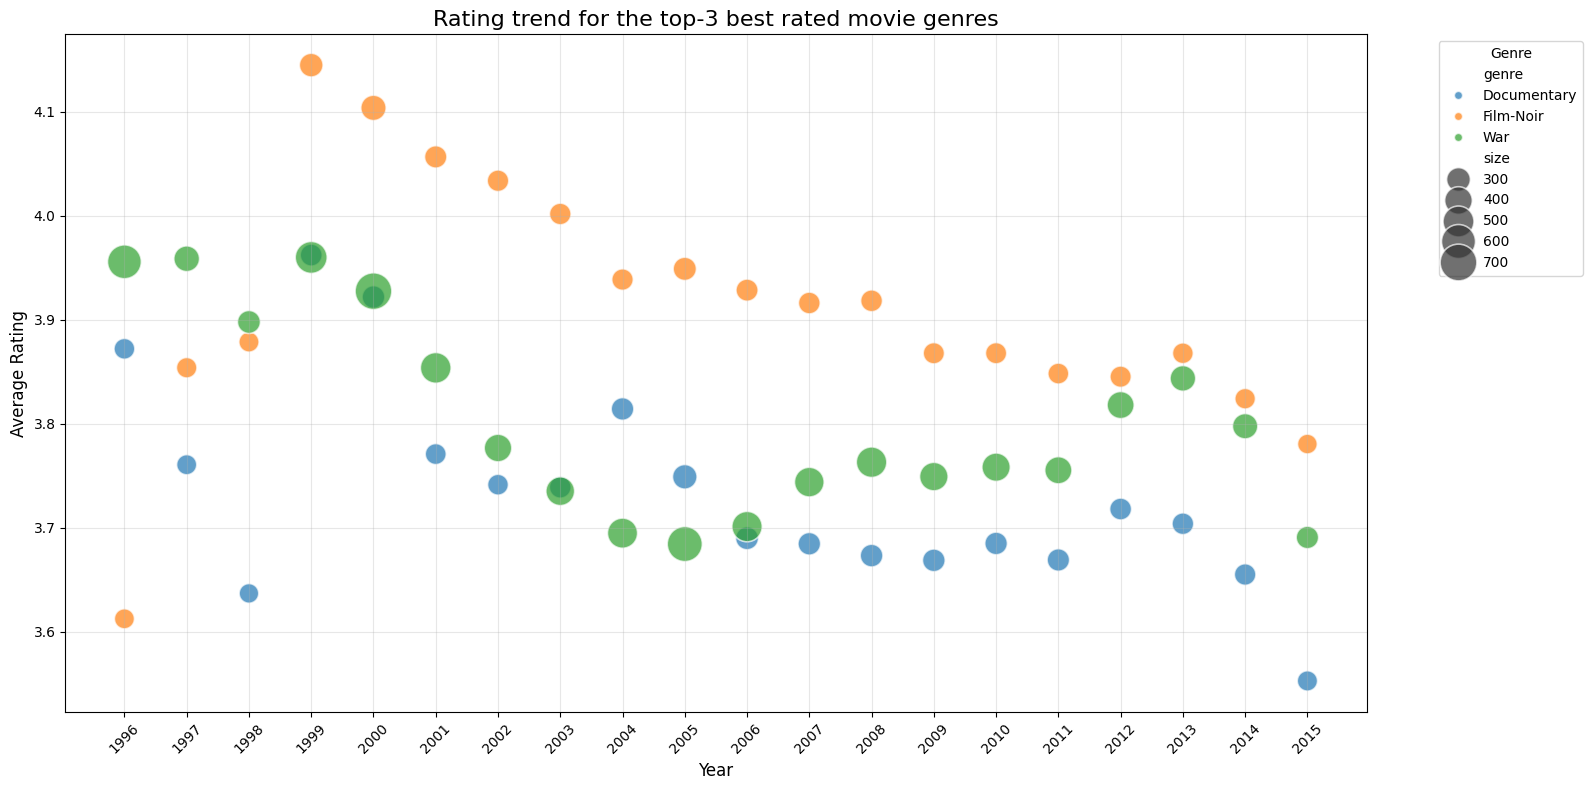

In [53]:
# Invoke show_scatterplot function with the top-3 best rated genres information
show_scatterplot(top_3_genres_movie_reviews_by_genre_and_year.toPandas(), "Rating trend for the top-3 best rated movie genres")

## Challenge!

Try plotting the same graph, but now for the _bottom 3 worst rated_ movie genres - how does it compare with the evolution of the top 3 genres?